In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision.transforms as transforms
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import itertools


import matplotlib.pyplot as plt

In [2]:
import numpy as np 
import pandas as pd
import os
print(os.listdir("emnist"))
import time

['emnist-test.csv', '.DS_Store', 'emnist-letters-train.csv', 'emnist-train.csv', 'emnist-letters-test.csv.zip', 'emnist-letters-train.csv.zip']


In [3]:
#X_train = pd.read_csv('digit-recognizer/train.csv')
#X_test = pd.read_csv('digit-recognizer/test.csv')

data = pd.read_csv('emnist/emnist-train.csv')

In [4]:
y = data.pop('label').values
X = data.values.reshape(-1,1,28,28)

In [5]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val,test_size=.33)

In [6]:
print("X_train shape ",X_train.shape)
print("X_val shape ",X_val.shape)
print("X_test shape ",X_test.shape)

X_train shape  (35000, 1, 28, 28)
X_val shape  (10050, 1, 28, 28)
X_test shape  (4950, 1, 28, 28)


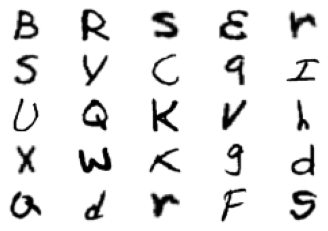

In [7]:
#plt.imshow(X_train[700].squeeze(), cmap='gray_r')
figure = plt.figure()
num_of_images = 25
rx =0
for index in range(1+rx, rx+num_of_images + 1):
    plt.subplot(5, 5, index-rx)
    plt.axis('off')
    plt.imshow(X_train[index].squeeze().transpose(1,0), cmap='gray_r')

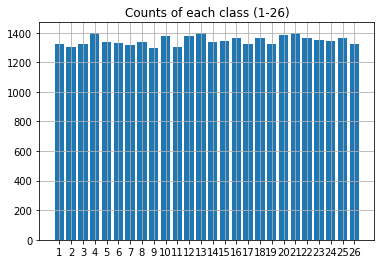

In [8]:
unique_labels,unique_label_counts = np.unique(y_train,return_counts=True)
plt.bar(unique_labels,unique_label_counts)
plt.title('Counts of each class (1-26)')
plt.xticks(unique_labels,unique_labels)
plt.grid()

In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(15,(.1,.1)),
    transforms.ToTensor()
])

In [10]:
X_train = [transform(X.transpose(1,2,0).astype(np.uint8)).unsqueeze(0) for X in X_train]
X_train = torch.cat(X_train,0) * 255

In [11]:
y_train,y_val,y_test,X_val,X_test = map(torch.tensor,(y_train,y_val,y_test,X_val,X_test))

In [12]:
X_train = (X_train).float()
X_val = (X_val).float()
X_test = (X_test).float()

y_train = y_train.long()-1
y_val = y_val.long()-1
y_test = y_test.long()-1

In [13]:
train_dl = DataLoader(TensorDataset(X_train,y_train),batch_size=1024)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,16,(3,3),padding=1) #(in,out,kernal)
        self.conv2 = nn.Conv2d(16,32,(3,3))
        self.conv3 = nn.Conv2d(32,64,(3,3),padding=1)
        self.conv4 = nn.Conv2d(64,128,(3,3))
        
        self.fc1 = nn.Linear(5*5*128,128) #in_features, out_features, bias=True)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,26)
        
    def forward(self,X):
        X = F.leaky_relu(self.conv1(X))
        X  = F.max_pool2d(F.leaky_relu(self.conv2(X)),(2,2))
        X = F.leaky_relu(self.conv3(X))
        X  = F.max_pool2d(F.leaky_relu(self.conv4(X)),(2,2))
        X = F.leaky_relu(self.fc1(X.view(-1,5*5*128)))
        X = F.leaky_relu(self.fc2(X))
        return self.fc3(X)

In [15]:
net = CNN()

In [16]:
lr = .005
#optimizer = optim.SGD(net.parameters(),lr=lr)
optimizer = optim.Adam(net.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [17]:
epochs = 8
training_loss = []
validation_loss = []
epoch_loss_min = 1000;
model_best_weights = {"epoch":0,"state_dict":net.state_dict()}

for epoch in range(epochs):
    epoch_loss = 0
    net.train()
    for xb,yb in train_dl:
        outcome = net(xb);
        loss = loss_fn(outcome,yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        with torch.no_grad():
            epoch_loss += len(xb) * loss
    scheduler.step()
    training_loss.append(epoch_loss/len(X_train))

    with torch.no_grad():
        net.eval()
        outcome = net(X_val)
        val_loss = loss_fn(outcome,y_val)
        validation_loss.append(val_loss)
        if epoch_loss_min > val_loss:
            model_best_weights = {"epoch":epoch,"state_dict":net.state_dict()}
            
    print("Epoch {0}/{1} : Training loss={2} Validation loss={3}".format(epoch+1,epochs,training_loss[epoch],validation_loss[epoch]))

Epoch 1/8 : Training loss=2.7303481101989746 Validation loss=0.9692333936691284
Epoch 2/8 : Training loss=0.8818154335021973 Validation loss=0.41554316878318787
Epoch 3/8 : Training loss=0.5119785666465759 Validation loss=0.323144793510437
Epoch 4/8 : Training loss=0.3673619031906128 Validation loss=0.3026626706123352
Epoch 5/8 : Training loss=0.25540921092033386 Validation loss=0.240386962890625
Epoch 6/8 : Training loss=0.21486982703208923 Validation loss=0.23892274498939514
Epoch 7/8 : Training loss=0.1997954249382019 Validation loss=0.23902180790901184
Epoch 8/8 : Training loss=0.18636612594127655 Validation loss=0.24083957076072693


In [20]:
# load in best model weights
print("Best epoch",model_best_weights["epoch"]+1)
net.load_state_dict(model_best_weights["state_dict"])

Best epoch 8


<All keys matched successfully>

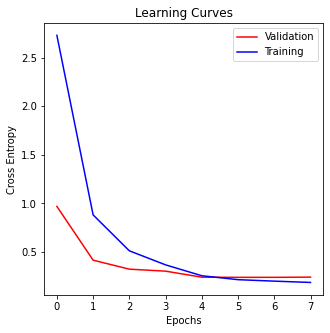

In [19]:
# learning curves
plt.figure(figsize=(5,5))
plt.plot(np.arange(epochs),validation_loss,'r-')
plt.plot(np.arange(epochs),training_loss,'b-')
plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy")
plt.legend(["Validation","Training"])
plt.show()

In [21]:
with torch.no_grad():
    y_pred = net(X_test)

In [22]:
print(classification_report(y_test,y_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       196
           1       0.93      0.96      0.94       184
           2       0.97      0.95      0.96       200
           3       0.96      0.94      0.95       212
           4       0.96      0.95      0.95       181
           5       0.98      0.94      0.96       194
           6       0.87      0.77      0.81       200
           7       0.91      0.93      0.92       183
           8       0.76      0.77      0.77       219
           9       0.95      0.91      0.93       175
          10       0.95      0.96      0.95       186
          11       0.74      0.75      0.74       193
          12       1.00      0.97      0.99       181
          13       0.93      0.95      0.94       182
          14       0.99      0.96      0.98       186
          15       0.98      0.98      0.98       186
          16       0.82      0.87      0.85       187
          17       0.90    

In [23]:
print(classification_report(y_test,y_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       196
           1       0.93      0.96      0.94       184
           2       0.97      0.95      0.96       200
           3       0.96      0.94      0.95       212
           4       0.96      0.95      0.95       181
           5       0.98      0.94      0.96       194
           6       0.87      0.77      0.81       200
           7       0.91      0.93      0.92       183
           8       0.76      0.77      0.77       219
           9       0.95      0.91      0.93       175
          10       0.95      0.96      0.95       186
          11       0.74      0.75      0.74       193
          12       1.00      0.97      0.99       181
          13       0.93      0.95      0.94       182
          14       0.99      0.96      0.98       186
          15       0.98      0.98      0.98       186
          16       0.82      0.87      0.85       187
          17       0.90    

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


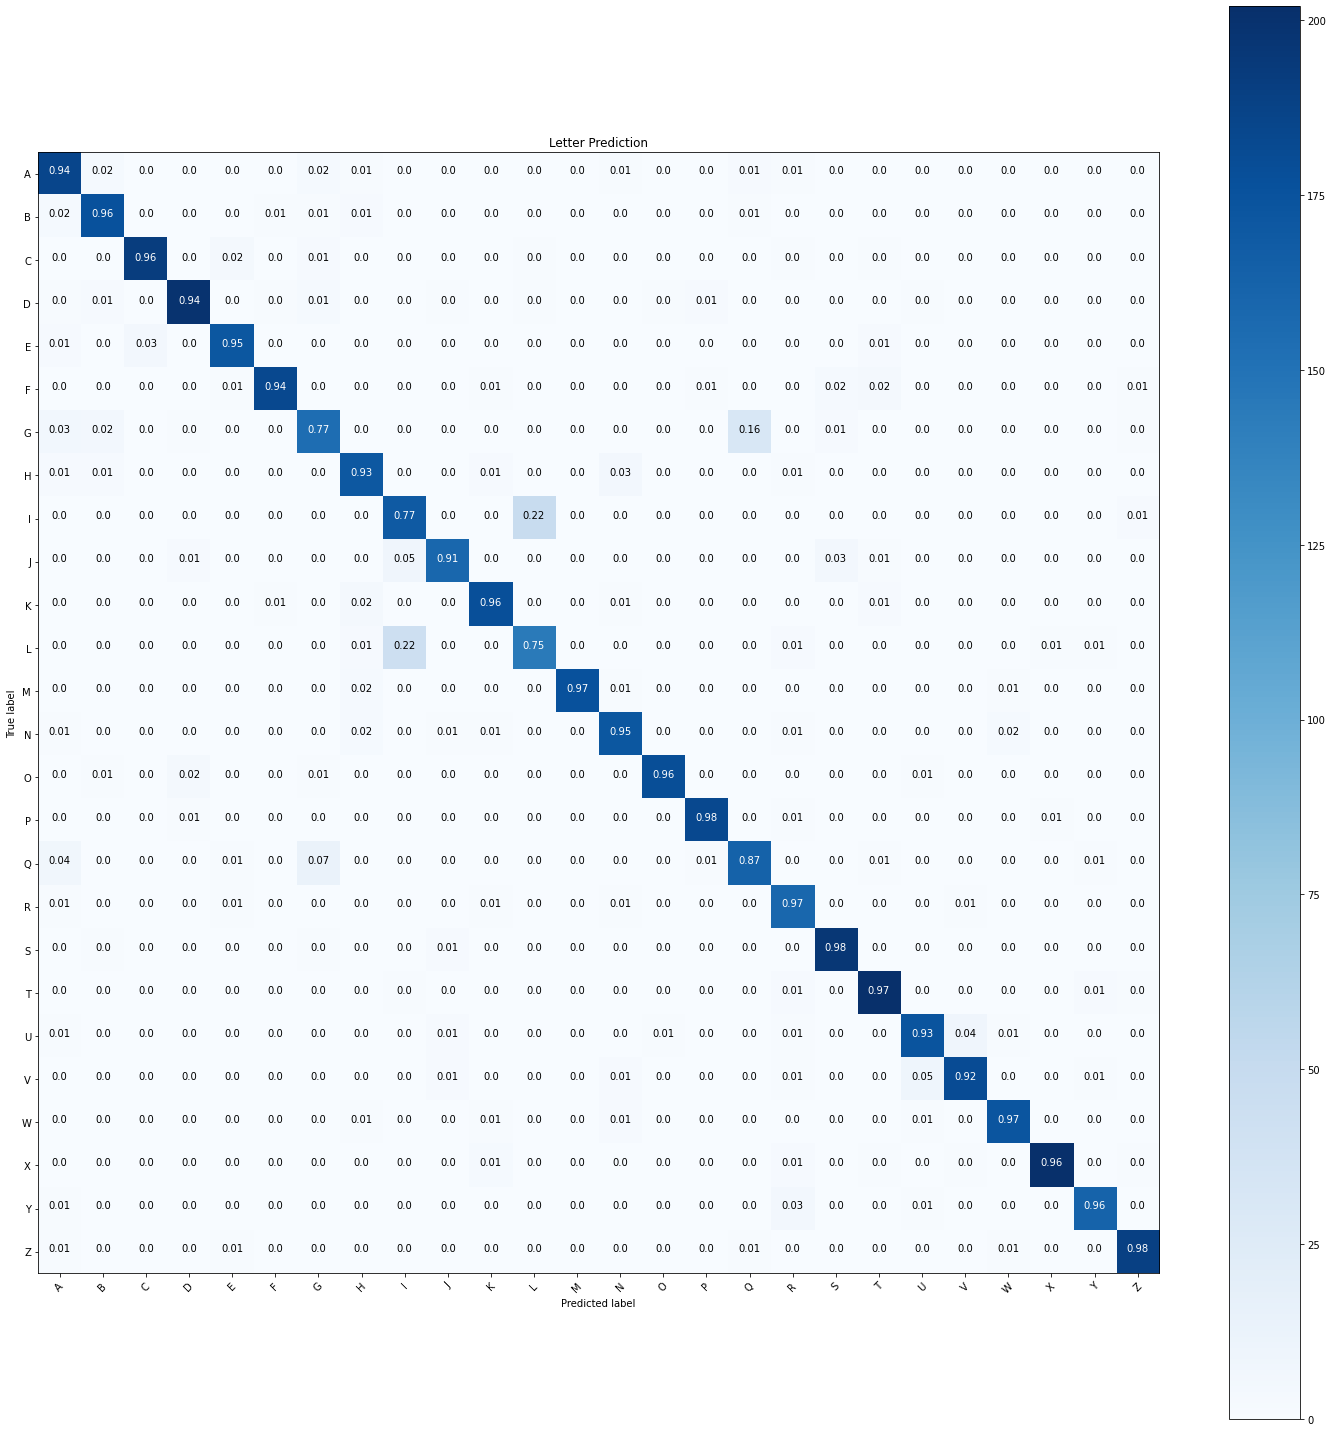

In [25]:
plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(y_test,y_pred.argmax(1))
classes = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
plot_confusion_matrix(cnf_matrix,classes=classes,normalize=True,title="Letter Prediction")

NameError: name 'bad_L_images' is not defined

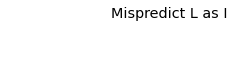

In [26]:
figure = plt.figure()
num_of_images = 25
rx =0
st = figure.suptitle("Mispredict L as I", fontsize="x-large")

for index in range(1+rx, rx+num_of_images + 1):
    plt.subplot(5, 5, index-rx)
    plt.axis('off')
    plt.imshow(bad_L_images[index].squeeze(0).transpose(1,0),cmap='gray_r')

#Test = y_train.values.reshape(-1,1,28,28)
#print(Test.shape)

In [ ]:
bad_L = (y_pred.argmax(1) != y_test) & (y_pred.argmax(1)==8) & (y_test==11)
bad_L_images = X_test[bad_L]

figure = plt.figure()
num_of_images = 25
rx =0
st = figure.suptitle("Mispredict I as L", fontsize="x-large")

for index in range(1+rx, rx+num_of_images + 1):
    plt.subplot(5, 5, index-rx)
    plt.axis('off')
    plt.imshow(bad_L_images[index].squeeze(0).transpose(1,0),cmap='gray_r')

#Test = y_train.values.reshape(-1,1,28,28)
#print(Test.shape)

In [ ]:
bad_L = (y_pred.argmax(1) != y_test) & (y_pred.argmax(1)==6) & (y_test==16)
bad_L_images = X_test[bad_L]

figure = plt.figure()
num_of_images = 16
rx =0
st = figure.suptitle("Mispredict G as Q", fontsize="x-large")

for index in range(1+rx, rx+num_of_images + 1):
    plt.subplot(4, 4, index-rx)
    plt.axis('off')
    plt.imshow(bad_L_images[index].squeeze(0).transpose(1,0),cmap='gray_r')

#Test = y_train.values.reshape(-1,1,28,28)
#print(Test.shape)

In [ ]:
bad_L = (y_pred.argmax(1) != y_test) & (y_pred.argmax(1)==16) & (y_test==6)
bad_L_images = X_test[bad_L]

figure = plt.figure()
num_of_images = 16
rx =0
st = figure.suptitle("Mispredict G as Q", fontsize="x-large")

for index in range(1+rx, rx+num_of_images + 1):
    plt.subplot(4, 4, index-rx)
    plt.axis('off')
    plt.imshow(bad_L_images[index].squeeze(0).transpose(1,0),cmap='gray_r')

#Test = y_train.values.reshape(-1,1,28,28)
#print(Test.shape)